# Homework Assignment 1
### [The Art of Analyzing Big Data - The Data Scientist’s Toolbox](https://www.ise.bgu.ac.il/labs/fire/lectures.html)
#### By Dr. Michael Fire 

For this homework you will need to write code that analyzes real-world datasets. The code needs to be written in Python using the [sqlite3](https://docs.python.org/2/library/sqlite3.html) package. 

**Please note:** You need to answer only the questions that match your ID first digit.

# 1. Babies Names Dataset (35pt)

**Task 1 (for everyone):** Write a code that uses the  [**babies names dataset**](https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-data-by-state-and-district-of-#topic=developers_navigation) and creates a table named (Names) with the dataset data and the following columns: 'State', 'Gender', 'Name', 'Number', and 'Year' (5pt)
**Bonus:** Load the data using a Batch INSERT SQL Query (2pt)

In [3]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [25]:
! rm -rf ./datasets
! mkdir ./datasets
! mkdir ./datasets/us-baby-name
# download the dataset using wget
! wget --directory-prefix ./datasets/us-baby-name https://www.ssa.gov/oact/babynames/state/namesbystate.zip
! unzip ./datasets/us-baby-name/*.zip  -d ./datasets/us-baby-name/namesbystate
# concatenate to one file
! cat ./datasets/us-baby-name/namesbystate/*.TXT >> ./datasets/us-baby-name/namesbystate.txt

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/us-baby-name’: File exists
--2020-10-22 11:12:57--  https://www.ssa.gov/oact/babynames/state/namesbystate.zip
Resolving www.ssa.gov (www.ssa.gov)... 137.200.4.16, 2001:1930:e03::aaaa
Connecting to www.ssa.gov (www.ssa.gov)|137.200.4.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22148032 (21M) [application/zip]
Saving to: ‘./datasets/us-baby-name/namesbystate.zip’

namesbystate.zip    100%[===================>]  21.12M   896KB/s    in 25s     

2020-10-22 11:13:22 (873 KB/s) - ‘./datasets/us-baby-name/namesbystate.zip’ saved [22148032/22148032]

Archive:  ./datasets/us-baby-name/namesbystate.zip
  inflating: ./datasets/us-baby-name/namesbystate/AK.TXT  
  inflating: ./datasets/us-baby-name/namesbystate/AL.TXT  
  inflating: ./datasets/us-baby-name/namesbystate/AR.TXT  
  inflating: ./datasets/us-baby-name/namesbystate/AZ.TXT  
  inflating: ./datasets/us-baby

In [28]:
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
TEXT_PATH = './datasets/us-baby-name/namesbystate.txt'
DB_PATH = './datasets/us-baby-name/namebystate.sqlite'

# Connect to the DB_PATH
conn = sqlite3.connect(DB_PATH) 

# Creating the cursor as Miki said
c = conn.cursor() 

# First we will start by creating the Names table.
c.execute(
        '''CREATE TABLE IF NOT EXISTS Names
             ([State] text,
              [Gender] text,
              [Year] integer,
              [Name] text,
              [Number] integer)
        '''
)

# After that we will read the text file with all the names
with open(TEXT_PATH) as f:
    names = f.readlines()

# Using list comprehension to create the list of values
names = [tuple(name.strip().split(",")) for name in names]

# Now insert all values from the columns that were asked
c.executemany(
    '''INSERT INTO Names(State, Gender, Year, Name, Number)
       values (?,?,?,?,?)
    ''', names
)

In [31]:
# Let's just check the first 5 rows
c.execute("SELECT * FROM Names").fetchall()[:5]

[('AK', 'F', 1910, 'Mary', 14),
 ('AK', 'F', 1910, 'Annie', 12),
 ('AK', 'F', 1910, 'Anna', 10),
 ('AK', 'F', 1910, 'Margaret', 8),
 ('AK', 'F', 1910, 'Helen', 7)]

**Task 2 (for everyone):** Write a query that returns the statistics for the name Mary (5pt). Use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run (5pt). **Bonus:** [Create an index](https://www.w3schools.com/sql/sql_create_index.asp)  on the _Name_ column and use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run with the index (5pt)

In [39]:
import time
import timeit

def Mary():
    return c.execute("SELECT COUNT(*) FROM Names WHERE Name='Mary'").fetchone()[0]

c.execute("DROP INDEX IF EXISTS idx_name")
print(f'Time without index:{timeit.timeit("Mary()", globals=globals(), number=5)}')

c.execute('''CREATE INDEX IF NOT EXISTS idx_name
             ON Names (name);''')
print(f'Time with index:{timeit.timeit("Mary()", globals=globals(), number=5)}')

Time without index:2.499174019999373
Time with index:0.0019533820004653535


In [40]:
print(f"Huge diff! {2.49//0.0019} times slower")

Huge diff! 1310.0 times slower


### <span style="color:red"> Please answer only **one** of the following questions according to your ID number (use the formula **<YOUR_ID> mod 4 +1**) </span>

In [38]:
# which question to answer - put your ID number and run the code 
your_id  = "305284515"
q = int(your_id) % 4 + 1
print("You need to answer question number %s" % q)

You need to answer question number 4


**Question 4:** Write a function that returns how many male babies named _Robert where born in a given state in a given year. Use it to find the state in which the highest number of babies _Robert_ where born in 2010 (10pt)

In [67]:
def find_babies(year, state=None):
    num = c.execute(
    f'''SELECT Number
        FROM Names
        WHERE State='{state}' AND
              Gender='M' AND
              Name='Robert' AND
              Year={year}
    '''
    ).fetchone()[0]
    return num

def find_babies_max():
  states = c.execute(
    f'''SELECT Distinct(State)
        FROM Names
    '''
    ).fetchall()
  states = [state[0] for state in states]
  max_num, max_state = 0, ''
  for state in states:
    curr_state_num = find_babies(2010, state)
    if curr_state_num > max_num:
      max_num = curr_state_num
      max_state = state
  print(f'State {max_state} has {max_num} Robert in 2010')


find_babies_max()

State CA has 853 Robert in 2010


**Question (for everyone):** For the state of CA write code that calculates the second most popular female/male names in each decade (10pt). **Bonus**: Visualize it somehow using Matplotlib (5pt)

In [112]:
def find_second_most(decade, gender):
  print(decade, gender, c.execute(
      f'''SELECT SUBSTR(Year, 1, 3), Gender, Name, Number
          FROM Names
          WHERE State='CA' AND
                Gender='{gender}' AND
                (SUBSTR(Year, 1, 3))='{int(decade / 10)}'
          GROUP BY SUBSTR(Year, 1, 3), Name
          ORDER BY 4 DESC LIMIT 2
      ''').fetchall()[1])
  
for decs in range(1910,2020,10):
  for gen in ['M','F']:
    find_second_most(decs, gen)

1910 M ('191', 'M', 'John', 1159)
1910 F ('191', 'F', 'Dorothy', 870)
1920 M ('192', 'M', 'John', 1528)
1920 F ('192', 'F', 'Barbara', 1378)
1930 M ('193', 'M', 'Richard', 2123)
1930 F ('193', 'F', 'Barbara', 1620)
1940 M ('194', 'M', 'Michael', 5364)
1940 F ('194', 'F', 'Mary', 3220)
1950 M ('195', 'M', 'Michael', 7456)
1950 F ('195', 'F', 'Karen', 3134)
1960 M ('196', 'M', 'David', 6566)
1960 F ('196', 'F', 'Michelle', 3829)
1970 M ('197', 'M', 'David', 4875)
1970 F ('197', 'F', 'Melissa', 3006)
1980 M ('198', 'M', 'Christopher', 6489)
1980 F ('198', 'F', 'Ashley', 4509)
1990 M ('199', 'M', 'Jose', 3870)
1990 F ('199', 'F', 'Samantha', 2787)
2000 M ('200', 'M', 'Anthony', 3088)
2000 F ('200', 'F', 'Sophia', 2662)
2010 M ('201', 'M', 'Liam', 2387)
2010 F ('201', 'F', 'Emma', 2385)


# 2. Flavors of Cacao Dataset (15pt)

Using the [Flavors of Cacao](https://www.kaggle.com/rombikuboktaeder/choco-flavors) dataset, answer the following questions:

**Question 1:** Write a function that returns the number of bars manufactured where the bars' BroadBean Origin is a given country. Use the function to calculate the number of bars where BroadBean Origin is 'Fiji' (15pt)

**Question 2:** Write a function that returns the maximal and average cocoa percentage in a bar manufactured by a company in a specific country. Use the function to calculate the minimal and average cocoa percentage in bars manufactured by a Swiss company (15pt).

**Question 3:** Calculate the second most common bean type(s) and the most rare bean type(s) (15
pt)

**Question 4:** Calculate the number of reviews and the average rating in each year. Calculate the number of reviews and the average rating of each company in each year (15pt)

In [10]:
!pip install pony

     |████████████████████████████████| 286kB 8.0MB/s 
  Created wheel for pony: filename=pony-0.7.13-cp36-none-any.whl size=345365 sha256=01556c19a2340c91cd53ddd7d86d3ce96c92c241b7ba553d70c4f5d0bf9704a3
  Stored in directory: /root/.cache/pip/wheels/ca/c7/66/a9192d0ea4bcb17a25164284ec89b4563a6afbf7333947c0ea
Successfully built pony


In [4]:
!kaggle datasets list -s choco_flavors
!kaggle datasets download rombikuboktaeder/choco-flavors -p ./datasets/choco-flavors/
!unzip ./datasets/choco-flavors/choco-flavors.zip -d ./datasets/choco-flavors/
!pip install pony

ref                             title          size  lastUpdated          downloadCount  
------------------------------  -------------  ----  -------------------  -------------  
rombikuboktaeder/choco-flavors  choco_flavors  30KB  2018-04-01 04:36:29            741  
  0% 0.00/30.3k [00:00<?, ?B/s]
100% 30.3k/30.3k [00:00<00:00, 52.7MB/s]
Archive:  ./datasets/choco-flavors/choco-flavors.zip
  inflating: ./datasets/choco-flavors/flavors_of_cacao.csv  


In [ ]:
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
DB_PATH = './datasets/choco-flavors/flavors_of_cacao.csv'

In [11]:
import pandas
import numpy as np

# pandas can find csv inside the zip itself
df = pandas.read_csv("./datasets/choco-flavors/choco-flavors.zip")
df = df.replace(np.nan, '', regex=True)

for idx, row in df.iterrows():
    ChocoFlavor(
            Company=row['Company\xa0\n(Maker-if known)'],
            BeanOrigin=row['Specific Bean Origin\nor Bar Name'],
            REF=row['REF'],
            ReviewDate=row['Review\nDate'],
            CocoaPrecent=row['Cocoa\nPercent'],
            Location=row['Company\nLocation'],
            Rating=row['Rating'],
            BeanType=row['Bean\nType'],
            BroadBeanOrigin=row['Broad Bean\nOrigin']
    )
show(ChocoFlavor)
commit()

class ChocoFlavor(Entity):
    id = PrimaryKey(int, auto=True)
    Company = Optional(str, default='')
    BeanOrigin = Required(str)
    REF = Required(int)
    ReviewDate = Required(int)
    CocoaPrecent = Required(str)
    Location = Required(str)
    Rating = Required(float)
    BeanType = Optional(str, default='')
    BroadBeanOrigin = Optional(str, default='')


In [13]:
# number of reviews and average rating per year
list(select((c.ReviewDate, count(c), avg(c.Rating)) for c in ChocoFlavor))

[(2006, 72, 3.125),
 (2007, 77, 3.1623376623376624),
 (2008, 93, 2.9946236559139785),
 (2009, 123, 3.073170731707317),
 (2010, 111, 3.1486486486486487),
 (2011, 165, 3.256060606060606),
 (2012, 195, 3.178205128205128),
 (2013, 184, 3.1970108695652173),
 (2014, 247, 3.1892712550607287),
 (2015, 285, 3.2464912280701754),
 (2016, 219, 3.2260273972602738),
 (2017, 24, 3.3125)]

In [15]:
# number of reviews and average rating per company per year
list(select((c.Company, c.ReviewDate, count(c), avg(c.Rating)) for c in ChocoFlavor))

[('A. Morin', 2012, 2, 3.625),
 ('A. Morin', 2013, 11, 3.3181818181818183),
 ('A. Morin', 2014, 5, 3.5),
 ('A. Morin', 2015, 4, 3.1875),
 ('A. Morin', 2016, 1, 3.75),
 ('AMMA', 2010, 4, 3.5625),
 ('AMMA', 2013, 1, 3.25),
 ('Acalli', 2015, 2, 3.75),
 ('Adi', 2011, 4, 3.25),
 ('Aequare (Gianduja)', 2009, 2, 2.875),
 ('Ah Cacao', 2009, 1, 3.0),
 ("Akesson's (Pralus)", 2010, 2, 2.75),
 ("Akesson's (Pralus)", 2011, 1, 3.75),
 ('Alain Ducasse', 2013, 2, 2.5),
 ('Alain Ducasse', 2014, 3, 2.8333333333333335),
 ('Alexandre', 2017, 4, 3.5),
 ('Altus aka Cao Artisan', 2013, 5, 3.0),
 ('Altus aka Cao Artisan', 2016, 5, 2.7),
 ('Amano', 2007, 3, 3.4166666666666665),
 ('Amano', 2008, 1, 2.75),
 ('Amano', 2009, 1, 3.0),
 ('Amano', 2010, 3, 3.5833333333333335),
 ('Amano', 2011, 1, 4.0),
 ('Amatller (Simon Coll)', 2009, 4, 2.875),
 ('Amazona', 2013, 2, 3.375),
 ('Ambrosia', 2015, 6, 3.25),
 ('Amedei', 2006, 2, 4.5),
 ('Amedei', 2007, 10, 3.725),
 ('Amedei', 2012, 1, 3.75),
 ('Anahata', 2014, 1, 3.0),
 

# 3. Kickstarter Projects Dataset (25pt)

Using the [Kickstarter Projects Dataset](https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv), answer the following questions:

**Task 1 (for everyone):** Load the dataset to SQLite DB using [PonyORM](https://ponyorm.org) (10pt)

In [7]:
!kaggle datasets list -s kickstarter-projects
!kaggle datasets download kemical/kickstarter-projects -p ./datasets/kickstarter-projects/
!unzip ./datasets/kickstarter-projects/*.zip  -d ./datasets/kickstarter-projects/

ref                                              title                                        size  lastUpdated          downloadCount  
-----------------------------------------------  ------------------------------------------  -----  -------------------  -------------  
kemical/kickstarter-projects                     Kickstarter Projects                         37MB  2018-02-08 09:02:30          43485  
codename007/funding-successful-projects          Funding Successful Projects on Kickstarter   20MB  2017-06-20 17:37:38           2702  
socathie/kickstarter-project-statistics          Kickstarter Project Statistics                1MB  2019-11-14 06:38:31           5735  
toshimelonhead/400000-kickstarter-projects       400,000 Kickstarter Projects                   0B  2019-07-23 01:23:31            230  
yashkantharia/kickstarter-campaigns              Kickstarter Campaigns                        12MB  2019-03-03 13:46:08            757  
uysalah/archived-kickstarter-projects    

In [11]:
from pony.orm import *
# Creating a new database
db_ks = Database()
db_ks.bind(provider='sqlite', filename='/content/datasets/kickstarter-projects/kickstarter-project.pony.db', create_db=True)

class KickstarterProject(db_ks.Entity):
    name = Optional(str) 
    category = Required(str)
    main_category = Required(str)
    currency = Required(str)
    deadline = Required(str)
    goal = Required(float)
    launched = Required(str)
    pledged = Required(float)
    launched = Required(str)
    state = Required(str)
    backers = Required(int)
    country = Required(str)
    usd_pledged = Optional(float)
    usd_pledged_real = Required(float)
    usd_goal_real = Required(float)

show(KickstarterProject)
#set_sql_debug(True) # helps to see what SQL commands are running
db_ks.generate_mapping(create_tables=True) # create tables

class KickstarterProject(Entity):
    id = PrimaryKey(int, auto=True)
    name = Optional(str, default='')
    category = Required(str)
    main_category = Required(str)
    currency = Required(str)
    deadline = Required(str)
    goal = Required(float)
    pledged = Required(float)
    launched = Required(str)
    state = Required(str)
    backers = Required(int)
    country = Required(str)
    usd_pledged = Optional(float)
    usd_pledged_real = Required(float)
    usd_goal_real = Required(float)


In [12]:
import pandas
import numpy as np

df_ks = pandas.read_csv("./datasets/kickstarter-projects/ks-projects-201801.csv")
df_ks['name'].fillna("", inplace=True)
df_ks['usd pledged'].fillna(0.0, inplace=True)

for idx, row in df_ks.iterrows():
    KickstarterProject(
            name=(row['name'] if not type(row['name']) is float else ""),
            category=row['category'],
            main_category=row['main_category'],
            currency=row['currency'],
            deadline=row['deadline'],
            goal=row['goal'],
            launched=row['launched'],
            pledged=row['pledged'],
            state=row['state'],
            backers=row['backers'],
            country=row['country'],
            usd_pledged=row['usd pledged'],
            usd_pledged_real=row['usd_pledged_real'],
            usd_goal_real=row['usd_goal_real'],
    )
commit()

### <span style="color:red"> Please answer only **one** of the following questions according to your ID number (use the formula **<YOUR_ID> mod 3 +1**) </span>

In [1]:
# which question to answer - put your ID number and run the code 
your_id  = "305284515"
q = int(your_id) % 3 + 1
print("You need to answer question number %s" % q)

You need to answer question number 1


**Question 1:** On average which project category received the highest number of backers? (15 pt)

In [26]:
avg_backers = select((k.category, avg(k.backers)) for k in KickstarterProject)
desc_avg_backers = avg_backers.order_by(lambda x,y: desc(y)).limit(1)
list(desc_avg_backers)

[('Chiptune', 443.9428571428571)]

**Question 2:** On average which project category received the highest pledged USD? (15 pt)

**Question 3:** In which month occurred the highest number of projects? (15 pt)

## 4. Oscars Datasets (10pt)

Using the [Oscars Dataset](https://www.kaggle.com/theacademy/academy-awards), please answer only one of the following questions (you can chose):

**Question 1:** Who is the male actress with the most Oscar nominees? (10pt)

In [27]:
# download and unzip dataset
!kaggle datasets list -s academy-awards
!kaggle datasets download theacademy/academy-awards -p ./datasets/academy-awards/
!unzip ./datasets/academy-awards/academy-awards.zip -d ./datasets/academy-awards/

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
theacademy/academy-awards                                   The Academy Awards, 1927-2015                       185KB  2017-02-13 17:30:48           5408  
fmejia21/demographics-of-academy-awards-oscars-winners      Demographics of Academy Awards (Oscars) Winners      20KB  2020-02-04 17:38:26           3106  
unanimad/the-oscar-award                                    The Oscar Award, 1927 - 2020                        191KB  2020-02-19 15:45:30           1300  
unanimad/golden-globe-awards                                Golden Globe Awards, 1944 - 2020                    117KB  2020-01-06 16:19:01           1874  
madhurinani/oscars-2017-tweets                              2017

In [28]:
from pony.orm import *
import pandas

# Creating a new database
db_aa = Database()
db_aa.bind(provider='sqlite', filename='/content/datasets/academy-awards/academy-awards.pony.db', create_db=True)

class AcademyAward(db_aa.Entity):
    Year = Required(str) 
    Ceremony = Required(int)
    Award = Required(str)
    Winner = Optional(float)
    Name = Required(str)
    Film = Optional(str)

show(AcademyAward)
#set_sql_debug(True)
db_aa.generate_mapping(create_tables=True)

class AcademyAward(Entity):
    id = PrimaryKey(int, auto=True)
    Year = Required(str)
    Ceremony = Required(int)
    Award = Required(str)
    Winner = Optional(float)
    Name = Required(str)
    Film = Optional(str, default='')


In [29]:
import pandas
import numpy as np

df_aa = pandas.read_csv("./datasets/academy-awards/database.csv")
df_aa['Winner'].fillna(0.0, inplace=True)

for idx, row in df_aa.iterrows():
    AcademyAward(
            Year=row['Year'],
            Ceremony=row['Ceremony'],
            Award=row['Award'],
            Winner=row['Winner'],
            Name=row['Name'],
            Film=(row['Film'] if not type(row['Film']) is float else "")
    )
commit()

In [39]:
most_nom = select((a.Name, count(a)) for a in AcademyAward).where(lambda a: a.Award == 'Actor' and a.Winner == 0.0)
most_nom_desc = most_nom.order_by(lambda x,y: desc(y)).limit(1)
list(most_nom_desc)

[('Spencer Tracy', 7)]

In [84]:
print("Bonus! see al his movies nomanies or winner!")
Spencer = select(a.Film for a in AcademyAward).where(lambda a: a.Name == 'Spencer Tracy')
list(Spencer)

Bonus! see al his movies nomanies or winner!


['San Francisco',
 'Captains Courageous',
 'Boys Town',
 'Father of the Bride',
 'Bad Day at Black Rock',
 'The Old Man and the Sea',
 'Inherit the Wind',
 'Judgment at Nuremberg',
 "Guess Who's Coming to Dinner"]

**Question 2:** Who is the female director with the most Oscar nominees? (10pt)

**Question 3:** Which top-10 movies received the highest number of Oscar nominees? (10pt)

**Question 4:** Write a function that receives an actor's name and returns the actor’s number of Oscar nominees. Use the function to calculate the number of times Leonardo DiCaprio was a nominee (10pt)

## 5. Select a Dataset (15pt)

**Open Question:** Select an interesting dataset and use SQL to discover something interesting (15pt). **Bonus:** Use BigQuery (2pt)

In [41]:
! kaggle datasets list

ref                                                               title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
nehaprabhavalkar/indian-food-101                                  Indian Food 101                                        7KB  2020-09-30 06:23:43           4521  
christianlillelund/donald-trumps-rallies                          Donald Trump's Rallies                               720KB  2020-09-26 10:25:08           1130  
heeraldedhia/groceries-dataset                                    Groceries dataset                                    257KB  2020-09-17 04:36:08           5072  
andrewmvd/trip-advisor-hotel-reviews                              Trip Advisor Hotel Reviews                             5MB  2020-09-30 08:31:20           3055  
balraj98/stanford-back

In [50]:
# download and unzip dataset
!kaggle datasets download arslanali4343/real-estate-dataset -p ./datasets/real-estate-dataset
!unzip ./datasets/real-estate-dataset/real-estate-dataset.zip -d ./datasets/real-estate-dataset/

  0% 0.00/11.7k [00:00<?, ?B/s]
100% 11.7k/11.7k [00:00<00:00, 16.1MB/s]
Archive:  ./datasets/real-estate-dataset/real-estate-dataset.zip
  inflating: ./datasets/real-estate-dataset/data.csv  


In [56]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [64]:
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
csv_path = './datasets/real-estate-dataset/data.csv'
DB_PATH = './datasets/real-estate-dataset/data.sqlite'

# Connect to the DB_PATH
conn = sqlite3.connect(DB_PATH) 

# Creating the cursor as Miki said
c = conn.cursor() 

# First we will start by creating the Names table.
c.execute(
        '''CREATE TABLE IF NOT EXISTS Real
             ([CRIM] double,
              [ZN] double,
              [INDUS] double,
              [CHAS] integer,
              [NOX] double,
              [RM] double,
              [AGE] double,
              [DIS] double,
              [RAD] integer,
              [TAX] integer,
              [PTRATIO] double,
              [B] double,
              [LSTAT] double,
              [MEDV] double)
        '''
)

# # After that we will read the text file with all the names
# with open(TEXT_PATH) as f:
#     names = f.readlines()

# # Using list comprehension to create the list of values
# names = [tuple(name.strip().split(",")) for name in names]

df = pandas.read_csv(csv_path)
# df.head()
# Now insert all values from the columns that were asked
c.executemany(
    '''INSERT INTO Real(CRIM,ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX,PTRATIO , B,LSTAT ,MEDV )
       values (?,?,?,?,?,?, ?,?,?,?,?, ?, ?, ?)
    ''', df.values
)

In [72]:
import matplotlib.pyplot as plt


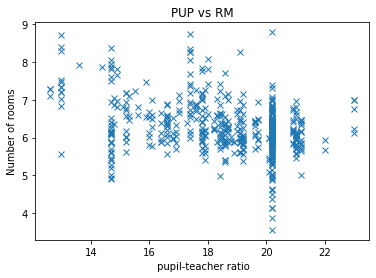

In [77]:
pup = list(c.execute("SELECT PTRATIO FROM Real").fetchall())
RM = list(c.execute("SELECT RM FROM Real").fetchall())
plt.plot(pup, RM, 'x')
plt.title("PUP vs RM")
plt.ylabel("Number of rooms")
plt.xlabel(" pupil-teacher ratio")
plt.show()

In [78]:
print("I wanted to check if the PUP ratio is smaller, that indicates that this is a good place to live in, and rich pepole live there, so they have many rooms")
print("Not sure the resuls realy show it, but it's a good start")

I wanted to check if the PUP ratio is smaller, that indicates that this is a good place to live in, and rich pepole live there, so they have many rooms
Not sure the resuls realy show it, but it's a good start
